In [5]:
import serial
import time
import mca.mca8000d as mca8000d
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import csv
import os

def connect_plh120p(port, baudrate=9600, timeout=2):
    """Connect to the PLH120P power supply."""
    try:
        ser = serial.Serial(port, baudrate, timeout=timeout)
        print(f"Connected to PLH120 P on port {port} with baudrate {baudrate}.")
        return ser
    except serial.SerialException as e:
        print(f"Error: {e}")
        print(
            f"Could not connect to PLH120 P on port {port}. Please ensure the device is "
            "connected, the port is correct, and no other program is using the port."
        )
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

def send_command(ser, command):
    """Send a command to the PLH120P."""
    if ser:
        ser.write(f"{command}\r\n".encode("ascii"))

def set_voltage_and_on(ser, voltage):
    """Set the voltage and turn the output on."""
    if ser:
        send_command(ser, f"V1 {voltage:.2f}")
        send_command(ser, "OP1 1")
        time.sleep(1)

def set_voltage(ser, voltage):
    """Sets the voltage of the power supply.

        Args:
            ser: serial port
            voltage: voltage value
    """
    if ser:
        send_command(ser, f"V1 {voltage:.2f}")
        time.sleep(0.5)  # Give some time for the voltage to settle

def turn_off_output(ser):
    """Turn the output off."""
    if ser:
        send_command(ser, "OP1 0")

def acquire_mca_spectrum(acquisition_time_seconds=5):
    """Acquire a spectrum using the MCA8000D."""
    try:
        mca = mca8000d.device()
        mca.enable_MCA_MCS()
        time.sleep(acquisition_time_seconds)
        mca.disable_MCA_MCS()
        spectrum_data, _ = mca.spectrum(False, bClear=True)
        num_channels = len(spectrum_data)
        bins = np.arange(num_channels)
        return bins, spectrum_data, None
    except Exception as e:
        error_message = f"Error during MCA acquisition: {e}"
        print(error_message)
        return None, None, error_message

def analyze_and_save_spectrum(spectrum_data, voltage, temperature, output_dir, measurement_num):
    """
    Analyzes the spectrum data, saves a plot,
    and returns peak values and heights.
    """
    print(f"Analyzing spectrum for Voltage: {voltage:.2f}V, Temperature: {temperature:.2f}°C, Measurement: {measurement_num}")
    num_channels = len(spectrum_data)
    bins = np.arange(num_channels)

    # Find Candidate Peaks
    peaks, properties = find_peaks(
        spectrum_data,
        height=100,
        distance=3,
        width=3
    )
    print(f"  Found {len(peaks)} candidate peaks.")

    peak_heights = properties.get("peak_heights", [])
    sorted_indices = np.argsort(peaks)
    peaks = peaks[sorted_indices].tolist()  # Convert to list for CSV writing
    if len(peak_heights) > 0:
        peak_heights = peak_heights[sorted_indices].tolist() # Convert to list
    else:
        peak_heights = []

    # Filter peaks (using a simpler approach here)
    filtered_peaks = peaks[:5]
    filtered_heights = peak_heights[:5]
    print(f"  Using first {len(filtered_peaks)} filtered peaks: Channels = {filtered_peaks}, Heights = {filtered_heights}")

    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    plt.plot(bins, spectrum_data, drawstyle='steps-mid', label='Spectrum')

    for i, peak in enumerate(filtered_peaks):
        plt.text(peak, spectrum_data[peak] * 1.1, f'{i}', ha='center', color='red')

    plt.xlim(0, 1000)
    plt.xlabel("Channel (Bin Number)")
    plt.ylabel("Counts")
    plt.title(f"SiPM Spectrum - Voltage: {voltage:.2f}V, Temperature: {temperature:.2f}°C")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    filename = os.path.join(output_dir, f"spectrum_v{voltage:.2f}_t{temperature:.2f}_measurement{measurement_num}.png")
    plt.savefig(filename)
    plt.close()
    print(f"  Spectrum plot saved to {filename}")

    return peaks[:5], peak_heights[:5]  # Return all peaks, not just filtered


def main():
    """
    Main function to control the power supply, acquire spectra over a range of voltages,
    and save the results. Takes the average of 3 measurements.
    """
    port_name = 'COM9'  # <--- CHANGE THIS TO YOUR POWER SUPPLY PORT
    voltage_range = np.arange(64.5, 70, 0.25)  # Manually input voltage range
    temperature = 10  # Manually input temperature
    acquisition_time = 4  # seconds
    output_dir = "Dark_peaks_10C"
    num_measurements = 3  # Number of measurements to average

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    else:
        print(f"Output directory exists: {output_dir}")

    csv_filename = os.path.join(output_dir, "mca_measurements_voltage_scan.csv")
    csv_header = ["Temperature (°C)", "Voltage (V)", "Measurement", "Peak Channels", "Peak Heights"]  # Added "Measurement"
    print(f"Preparing to save data to CSV file: {csv_filename}")
    with open(csv_filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(csv_header)
        print(f"CSV header written: {csv_header}")

    plh120p_serial = connect_plh120p(port_name)
    if plh120p_serial is None:
        print("Could not connect to the power supply. Exiting.")
        return

    for i, voltage in enumerate(voltage_range):
        print(f"\n--- Processing Voltage: {voltage:.2f} V (Measurement {i+1}/{len(voltage_range)}) ---")
        print(f"  Setting voltage to {voltage:.2f} V...")
        set_voltage_and_on(plh120p_serial, voltage)
        time.sleep(2)  # Allow time for voltage to stabilize

        for measurement_num in range(num_measurements):
            print(f"  Acquiring measurement {measurement_num + 1}...")
            bins, spectrum_data, error = acquire_mca_spectrum(acquisition_time)
            if spectrum_data is not None:
                peaks, heights = analyze_and_save_spectrum(spectrum_data, voltage, temperature, output_dir, measurement_num + 1)
                # Save ALL peaks and heights for each measurement
                csv_row = [f"{temperature:.2f}", f"{voltage:.2f}", measurement_num + 1, peaks, heights]
                with open(csv_filename, 'a', newline='') as csvfile:
                    csv_writer = csv.writer(csvfile)
                    csv_writer.writerow(csv_row)
                print(f"  Wrote row to CSV: {csv_row}")
            else:
                print(f"Skipping measurement {measurement_num + 1} due to acquisition error: {error}")
                # Handle the error.  For simplicity, we'll just skip this measurement
                # In a real application, you might want to retry, or stop the sequence.
                continue

        turn_off_output(plh120p_serial)
    plh120p_serial.close()
    print("Power supply output turned off and serial connection closed.")
    print(f"\nAll measurements complete. Results saved to {csv_filename} and plots in {output_dir}/")

    # --- Post-processing: Calculate and plot average peak distances ---
    print("\n--- Post-processing: Calculating and plotting average peak distances ---")
    peak_data = {}  # Store peaks for each (voltage, temp)
    with open(csv_filename, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            try:
                temperature = float(row['Temperature (°C)'])
                voltage = float(row['Voltage (V)'])
                measurement = int(row['Measurement'])  # Get measurement number
                peaks_str = row['Peak Channels'].strip('[]').replace(' ', '')
                peaks = [float(p) for p in peaks_str.split(',')] if peaks_str else []  # Handle empty peak list

                if (temperature, voltage) not in peak_data:
                    peak_data[(temperature, voltage)] = []
                peak_data[(temperature, voltage)].append(peaks)  # Store peaks for each measurement
            except ValueError as e:
                print(f"Error reading row: {row}. Skipping. Error: {e}")
                continue

    avg_peak_distances = {}
    for (temperature, voltage), all_peaks_for_this_condition in peak_data.items():
        distances = []
        for measurement_peaks in all_peaks_for_this_condition:
            if len(measurement_peaks) > 1:
                distances.extend(np.diff(measurement_peaks))  # Get distances between consecutive peaks
        if distances:
            avg_peak_distances[(temperature, voltage)] = np.mean(distances)
        else:
            avg_peak_distances[(temperature, voltage)] = None # Handle the case where there are not enough peaks

    # Plotting average peak distances
    voltages = sorted(list(set(v for _, v in avg_peak_distances.keys())))
    temperatures = sorted(list(set(t for t, _ in avg_peak_distances.keys())))

    plt.figure(figsize=(10, 6))
    for temp in temperatures:
        distances_at_temp = [avg_peak_distances.get((temp, v)) for v in voltages]
        valid_voltages = [v for i, v in enumerate(voltages) if distances_at_temp[i] is not None]
        valid_distances = [d for d in distances_at_temp if d is not None]
        if valid_voltages:
            plt.plot(valid_voltages, valid_distances, marker='o', label=f'Temp {temp:.2f} °C')
    plt.xlabel('Voltage (V)')
    plt.ylabel('Average Peak Distance (Channels)')
    plt.title('Average Peak Distance vs. Voltage')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    for voltage in voltages:
        distances_at_voltage = [avg_peak_distances.get((temp, voltage)) for temp in temperatures]
        valid_temperatures = [t for i, t in enumerate(temperatures) if distances_at_voltage[i] is not None]
        valid_distances = [d for d in distances_at_voltage if d is not None]
        if valid_temperatures:
            plt.plot(valid_temperatures, valid_distances, marker='o', label=f'Voltage {voltage:.2f} V')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Average Peak Distance (Channels)')
    plt.title('Average Peak Distance vs. Temperature')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    main()


Output directory exists: Dark_peaks_10C
Preparing to save data to CSV file: Dark_peaks_10C\mca_measurements_voltage_scan.csv
CSV header written: ['Temperature (°C)', 'Voltage (V)', 'Measurement', 'Peak Channels', 'Peak Heights']
Connected to PLH120 P on port COM9 with baudrate 9600.

--- Processing Voltage: 64.50 V (Measurement 1/22) ---
  Setting voltage to 64.50 V...


Exception ignored in: <function device.__del__ at 0x0000021380487790>
Traceback (most recent call last):
  File "c:\Users\DBouc\OneDrive\Bureaublad\THESIS2025\mca\mca8000d.py", line 295, in __del__
    self.dev.reset()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 973, in reset
    self._ctx.managed_open()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 113, in wrapper
    return f(self, *args, **kwargs)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 132, in managed_open
    self.handle = self.backend.open_device(self.dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 808, in open_device
    return _DeviceHandle(dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 656, in __init__
    _check(_lib.libusb_open(self.devid, byref(self.handle)))
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _check
    raise 

  Acquiring measurement 1...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 1 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 2...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 2 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 3...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 3 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)

--- Processing Voltage: 64.75 

Exception ignored in: <function device.__del__ at 0x0000021380487790>
Traceback (most recent call last):
  File "c:\Users\DBouc\OneDrive\Bureaublad\THESIS2025\mca\mca8000d.py", line 295, in __del__
    self.dev.reset()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 973, in reset
    self._ctx.managed_open()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 113, in wrapper
    return f(self, *args, **kwargs)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 132, in managed_open
    self.handle = self.backend.open_device(self.dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 808, in open_device
    return _DeviceHandle(dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 656, in __init__
    _check(_lib.libusb_open(self.devid, byref(self.handle)))
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _check
    raise 

  Acquiring measurement 1...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 1 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 2...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 2 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 3...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 3 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)

--- Processing Voltage: 65.00 

Exception ignored in: <function device.__del__ at 0x0000021380487790>
Traceback (most recent call last):
  File "c:\Users\DBouc\OneDrive\Bureaublad\THESIS2025\mca\mca8000d.py", line 295, in __del__
    self.dev.reset()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 973, in reset
    self._ctx.managed_open()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 113, in wrapper
    return f(self, *args, **kwargs)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 132, in managed_open
    self.handle = self.backend.open_device(self.dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 808, in open_device
    return _DeviceHandle(dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 656, in __init__
    _check(_lib.libusb_open(self.devid, byref(self.handle)))
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _check
    raise 

  Acquiring measurement 1...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 1 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 2...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 2 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 3...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 3 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)

--- Processing Voltage: 65.25 

Exception ignored in: <function device.__del__ at 0x0000021380487790>
Traceback (most recent call last):
  File "c:\Users\DBouc\OneDrive\Bureaublad\THESIS2025\mca\mca8000d.py", line 295, in __del__
    self.dev.reset()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 973, in reset
    self._ctx.managed_open()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 113, in wrapper
    return f(self, *args, **kwargs)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 132, in managed_open
    self.handle = self.backend.open_device(self.dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 808, in open_device
    return _DeviceHandle(dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 656, in __init__
    _check(_lib.libusb_open(self.devid, byref(self.handle)))
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _check
    raise 

  Acquiring measurement 1...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 1 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 2...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 2 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 3...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 3 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)

--- Processing Voltage: 65.50 

Exception ignored in: <function device.__del__ at 0x0000021380487790>
Traceback (most recent call last):
  File "c:\Users\DBouc\OneDrive\Bureaublad\THESIS2025\mca\mca8000d.py", line 295, in __del__
    self.dev.reset()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 973, in reset
    self._ctx.managed_open()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 113, in wrapper
    return f(self, *args, **kwargs)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 132, in managed_open
    self.handle = self.backend.open_device(self.dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 808, in open_device
    return _DeviceHandle(dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 656, in __init__
    _check(_lib.libusb_open(self.devid, byref(self.handle)))
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _check
    raise 

  Acquiring measurement 1...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 1 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 2...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 2 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 3...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 3 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)

--- Processing Voltage: 65.75 

Exception ignored in: <function device.__del__ at 0x0000021380487790>
Traceback (most recent call last):
  File "c:\Users\DBouc\OneDrive\Bureaublad\THESIS2025\mca\mca8000d.py", line 295, in __del__
    self.dev.reset()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 973, in reset
    self._ctx.managed_open()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 113, in wrapper
    return f(self, *args, **kwargs)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 132, in managed_open
    self.handle = self.backend.open_device(self.dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 808, in open_device
    return _DeviceHandle(dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 656, in __init__
    _check(_lib.libusb_open(self.devid, byref(self.handle)))
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _check
    raise 

  Acquiring measurement 1...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 1 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 2...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 2 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 3...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 3 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)

--- Processing Voltage: 66.00 

Exception ignored in: <function device.__del__ at 0x0000021380487790>
Traceback (most recent call last):
  File "c:\Users\DBouc\OneDrive\Bureaublad\THESIS2025\mca\mca8000d.py", line 295, in __del__
    self.dev.reset()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 973, in reset
    self._ctx.managed_open()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 113, in wrapper
    return f(self, *args, **kwargs)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 132, in managed_open
    self.handle = self.backend.open_device(self.dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 808, in open_device
    return _DeviceHandle(dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 656, in __init__
    _check(_lib.libusb_open(self.devid, byref(self.handle)))
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _check
    raise 

  Acquiring measurement 1...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 1 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 2...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 2 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 3...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 3 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)

--- Processing Voltage: 66.25 

Exception ignored in: <function device.__del__ at 0x0000021380487790>
Traceback (most recent call last):
  File "c:\Users\DBouc\OneDrive\Bureaublad\THESIS2025\mca\mca8000d.py", line 295, in __del__
    self.dev.reset()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 973, in reset
    self._ctx.managed_open()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 113, in wrapper
    return f(self, *args, **kwargs)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 132, in managed_open
    self.handle = self.backend.open_device(self.dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 808, in open_device
    return _DeviceHandle(dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 656, in __init__
    _check(_lib.libusb_open(self.devid, byref(self.handle)))
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _check
    raise 

  Acquiring measurement 1...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 1 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 2...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 2 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 3...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 3 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)

--- Processing Voltage: 66.50 

Exception ignored in: <function device.__del__ at 0x0000021380487790>
Traceback (most recent call last):
  File "c:\Users\DBouc\OneDrive\Bureaublad\THESIS2025\mca\mca8000d.py", line 295, in __del__
    self.dev.reset()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 973, in reset
    self._ctx.managed_open()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 113, in wrapper
    return f(self, *args, **kwargs)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 132, in managed_open
    self.handle = self.backend.open_device(self.dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 808, in open_device
    return _DeviceHandle(dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 656, in __init__
    _check(_lib.libusb_open(self.devid, byref(self.handle)))
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _check
    raise 

  Acquiring measurement 1...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 1 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 2...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 2 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 3...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 3 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)

--- Processing Voltage: 66.75 

Exception ignored in: <function device.__del__ at 0x0000021380487790>
Traceback (most recent call last):
  File "c:\Users\DBouc\OneDrive\Bureaublad\THESIS2025\mca\mca8000d.py", line 295, in __del__
    self.dev.reset()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 973, in reset
    self._ctx.managed_open()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 113, in wrapper
    return f(self, *args, **kwargs)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 132, in managed_open
    self.handle = self.backend.open_device(self.dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 808, in open_device
    return _DeviceHandle(dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 656, in __init__
    _check(_lib.libusb_open(self.devid, byref(self.handle)))
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _check
    raise 

  Acquiring measurement 1...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 1 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 2...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 2 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
  Acquiring measurement 3...
Error setting configuration: [Errno 13] Access denied (insufficient permissions)
Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)
Skipping measurement 3 due to acquisition error: Error during MCA acquisition: [Errno 13] Access denied (insufficient permissions)

--- Processing Voltage: 67.00 

KeyboardInterrupt: 

Average peak distance at 64.5V: 27.67 channels
Average peak distance at 64.5V: 25.67 channels
Average peak distance at 64.5V: 27.67 channels
Average peak distance at 64.75V: 27.33 channels
Average peak distance at 64.75V: 26.67 channels
Average peak distance at 64.75V: 27.33 channels
Average peak distance at 65.0V: 27.00 channels
Average peak distance at 65.0V: 26.67 channels
Average peak distance at 65.0V: 27.00 channels
Average peak distance at 65.25V: 23.33 channels
Average peak distance at 65.25V: 26.67 channels
Average peak distance at 65.25V: 26.33 channels
Average peak distance at 65.5V: 23.67 channels
Average peak distance at 65.5V: 26.00 channels
Average peak distance at 65.5V: 23.67 channels
Average peak distance at 65.75V: 25.67 channels
Average peak distance at 65.75V: 22.67 channels
Average peak distance at 65.75V: 22.67 channels
Average peak distance at 66.0V: 22.33 channels
Average peak distance at 66.0V: 37.00 channels
Average peak distance at 66.0V: 45.00 channels
Aver

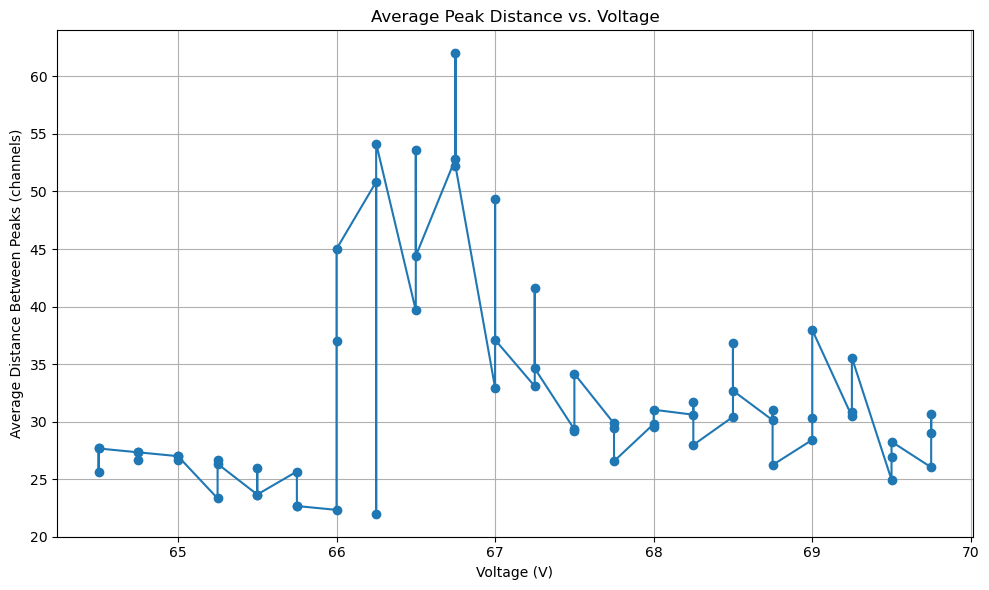

In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def analyze_gain_from_csv(csv_file):
    """
    Analyzes a CSV file containing MCA spectrum data at different voltages
    and calculates the average distance between peaks at each voltage.
    Args:
        csv_file (str): Path to the CSV file.
    Returns:
        None: Displays a plot.
    """
    voltages = []
    peak_channels_data = []
    peak_distances = []  # List to store peak distances for each voltage

    with open(csv_file, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            try:
                voltage_str = row.get('Voltage (V)')  # Use .get() to handle missing keys
                if voltage_str is not None:
                    voltage = float(voltage_str)
                else:
                    print(f"Warning: 'Voltage (V)' is missing in row: {row}. Skipping row.")
                    continue  # Skip the rest of the processing for this row

                peak_channels_str = row.get('Peak Channels')
                if peak_channels_str:
                    peak_channels_str = peak_channels_str.strip('[]').replace(' ', '')
                    peak_channels = [float(p) for p in peak_channels_str.split(',')]
                else:
                    print(f"Warning: 'Peak Channels' is missing in row: {row}. Skipping row.")
                    continue

                voltages.append(voltage)
                peak_channels_data.append(peak_channels)
            except (ValueError, KeyError) as e:
                print(f"Error reading row: {row}. Skipping. Error: {e}")

    if not voltages or not peak_channels_data:
        print("No valid data found in the CSV file.")
        return

    for i, peaks in enumerate(peak_channels_data):
        if len(peaks) >= 2:
            # Calculate differences between consecutive peaks
            distances = np.diff(peaks)
            average_distance = np.mean(distances)  # Calculate the average
            peak_distances.append(average_distance)
            print(f"Average peak distance at {voltages[i]}V: {average_distance:.2f} channels")
        else:
            print(f"Not enough peaks found in spectrum at {voltages[i]}V to calculate gain difference.")
            peak_distances.append(None)  # Append None if not enough peaks

    # Plotting
    plt.figure(figsize=(10, 6))
    # Filter out None values from voltages and peak_distances for plotting
    valid_voltages = [v for i, v in enumerate(voltages) if peak_distances[i] is not None]
    valid_distances = [d for d in peak_distances if d is not None]

    if valid_voltages and valid_distances:
        plt.plot(valid_voltages, valid_distances, marker='o')
        plt.xlabel("Voltage (V)")
        plt.ylabel("Average Distance Between Peaks (channels)")
        plt.title("Average Peak Distance vs. Voltage")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data to plot.")

if __name__ == "__main__":
    csv_file_path = "Dark_peaks_10C/mca_measurements_voltage_scan.csv"  # Replace with your CSV file path
    analyze_gain_from_csv(csv_file_path)


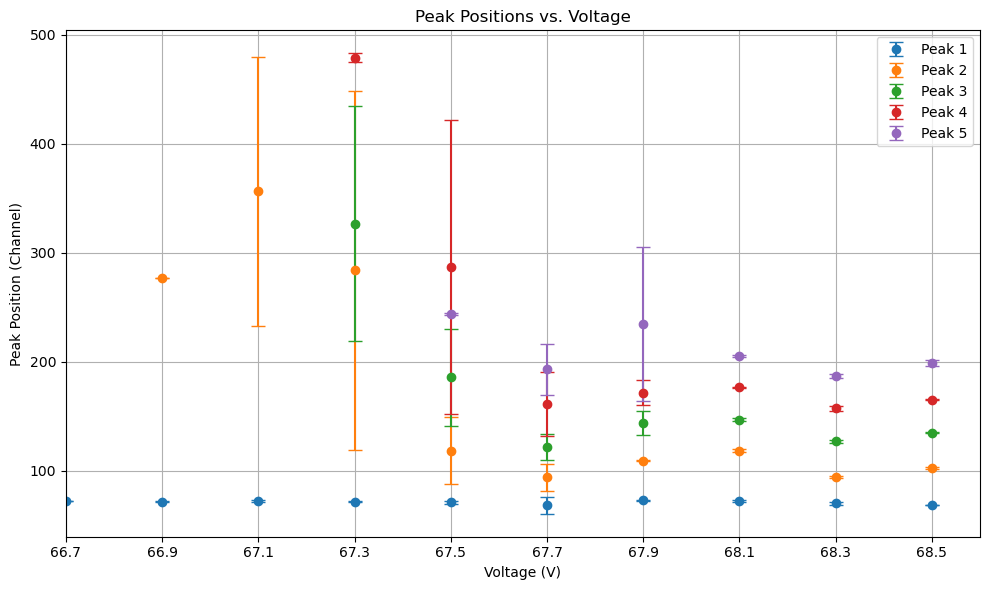

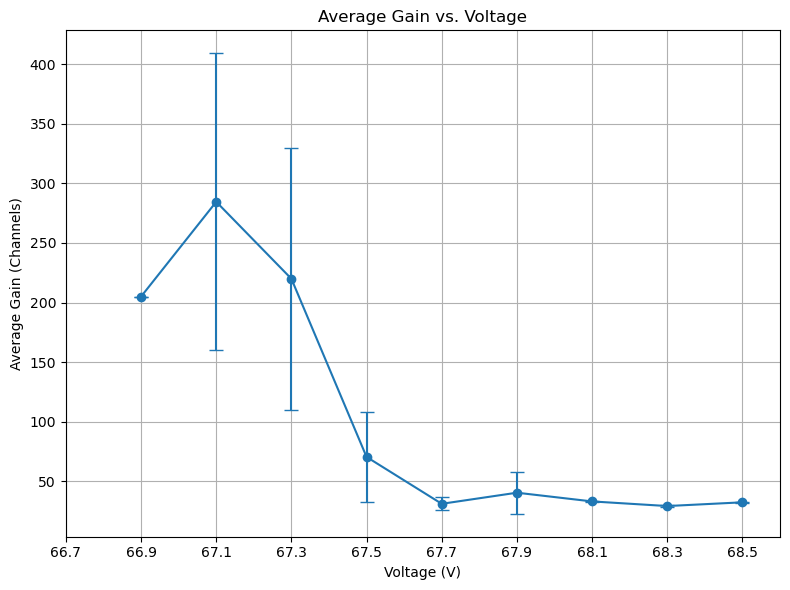

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_peak_positions_with_error_bars(filename):
    """
    Plots the peak positions (channel numbers) with error bars for each voltage from a CSV file.

    Args:
        filename (str): The name of the CSV file.
    """
    try:
        df = pd.read_csv(filename)
        voltages = df["Voltage"].unique()
        peak_data = {}

        # Extract peak data for each voltage
        for voltage in voltages:
            voltage_df = df[df["Voltage"] == voltage]
            peaks = []
            for i in range(5):  # Iterate through the first 5 peaks
                peak_values = voltage_df[f"Peak_{i+1}_Run_1"].dropna().tolist() + \
                              voltage_df[f"Peak_{i+1}_Run_2"].dropna().tolist() + \
                              voltage_df[f"Peak_{i+1}_Run_3"].dropna().tolist() + \
                              voltage_df[f"Peak_{i+1}_Run_4"].dropna().tolist()
                if len(peak_values) > 0:
                  peaks.append(peak_values)
            peak_data[voltage] = peaks

        # Plot peak positions vs. voltage with error bars
        plt.figure(figsize=(10, 6))
        for i in range(5): # changed to 5
            peak_positions = []
            peak_errors = []
            voltage_values = []
            for voltage in voltages:
                if i < len(peak_data[voltage]):
                    peak_positions.append(np.mean(peak_data[voltage][i]))
                    peak_errors.append(np.std(peak_data[voltage][i]))
                    voltage_values.append(voltage)
                else:
                    peak_positions.append(np.nan)
                    peak_errors.append(np.nan)
                    voltage_values.append(voltage)
            plt.errorbar(
                voltage_values,
                peak_positions,
                yerr=peak_errors,
                fmt="o",
                label=f"Peak {i+1}",
                capsize=5,
            )
        plt.xlabel("Voltage (V)")
        plt.ylabel("Peak Position (Channel)")
        plt.xlim(67.6,68.6)

        plt.title("Peak Positions vs. Voltage")
        plt.xticks(voltages)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found - {filename}")
    except KeyError:
        print("Error: Invalid data format in CSV file.  Expected columns 'Voltage' and 'Peak_n_Run_m'.")
    except Exception as e:
        print(f"An error occurred: {e}")

def plot_gain_with_error_bars(filename):
    """
    Calculates and plots the average gain with error bars for each voltage from a CSV file.

    Args:
        filename (str): The name of the CSV file.
    """
    try:
        df = pd.read_csv(filename)
        voltages = df["Voltage"].unique()
        gain_data = {}

        # Calculate gain for each voltage and run
        for voltage in voltages:
            voltage_df = df[df["Voltage"] == voltage]
            gains = []
            for run in range(1, 5):
                peaks = []
                for i in range(5):
                    peak_val = voltage_df[f"Peak_{i+1}_Run_{run}"].iloc[0]
                    if not np.isnan(peak_val):
                        peaks.append(peak_val)
                if len(peaks) >= 2:
                    gains.append(np.mean(np.diff(peaks)))
                else:
                    gains.append(np.nan)
            gain_data[voltage] = gains

        # Calculate average gain and error for each voltage
        avg_gains = []
        gain_errors = []
        voltage_values = []
        for voltage in voltages:
            valid_gains = [g for g in gain_data[voltage] if not np.isnan(g)] #filter out nans
            if valid_gains:
                avg_gains.append(np.mean(valid_gains))
                gain_errors.append(np.std(valid_gains))
                voltage_values.append(voltage)
            else:
                avg_gains.append(np.nan)
                gain_errors.append(np.nan)
                voltage_values.append(voltage)

        # Plot average gain vs. voltage with error bars
        plt.figure(figsize=(8, 6))
        plt.xlim(67.6,68.6)

        plt.errorbar(
            voltage_values,
            avg_gains,
            yerr=gain_errors,
            fmt="o-",
            capsize=5,
        )
        plt.xlabel("Voltage (V)")
        plt.ylabel("Average Gain (Channels)")
        plt.title("Average Gain vs. Voltage")
        plt.xticks(voltages)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found - {filename}")
    except KeyError:
        print("Error: Invalid data format in CSV file.  Expected columns 'Voltage' and 'Peak_n_Run_m'.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    filename = "peak_data_20C.csv"  # Replace with the actual filename
    plot_peak_positions_with_error_bars(filename)
    plot_gain_with_error_bars(filename)


In [ ]:
import pyvisa
import serial
import csv
import numpy as np
import time
import os
import mca.mca8000d as mca8000d
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# ================== CONFIGURATION ==================
PLH120P_PORT = "COM6"  # Replace with your PLH120P serial port
ARDUINO_PORT = "COM5"  # Arduino port
BAUD_RATE = 115200
DATA_FOLDER = "mca_data"
TEMP_TOLERANCE = 0.2
STABILIZATION_TIMEOUT = 900  # seconds
REQUIRED_STABLE_READINGS = 6
NUM_RUNS = 4
ACQUISITION_TIME = 5  # seconds

# ================== VOLTAGE SWEEP ==================
voltage_points = np.arange(67.7, 69.3, 0.2)  # Example voltage points

# ================== INITIALIZE DEVICES ==================
print("Connecting to Arduino...")
try:
    arduino = serial.Serial(ARDUINO_PORT, BAUD_RATE, timeout=3)
    time.sleep(2)
except serial.SerialException as e:
    print(f"Error: Could not connect to Arduino: {e}")
    arduino = None  # Set to None to prevent further errors

# ================== PLH120P SETUP ==================
def connect_plh120p(port, baudrate=9600, timeout=2):
    """Connect to the PLH120P power supply."""
    try:
        ser = serial.Serial(port, baudrate, timeout=timeout)
        print(f"Connected to PLH120 P on port {port} with baudrate {baudrate}.")
        return ser
    except serial.SerialException as e:
        print(f"Error: {e}")
        print(
            f"Could not connect to PLH120 P on port {port}.  Please ensure the device is "
            "connected, the port is correct, and no other program is using the port."
        )
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None
        
print("Connecting to PLH120P...")
plh120p_serial = connect_plh120p(PLH120P_PORT)
if plh120p_serial is None:
    print("Failed to connect to PLH120P.  Exiting.")
    exit()



def send_command(ser, command):
    """Send a command to the PLH120P."""
    if ser:
        ser.write(f"{command}\r\n".encode("ascii"))


def set_voltage_and_on(ser, voltage):
    """Set the voltage and turn the output on."""
    if ser:
        send_command(ser, f"V1 {voltage:.2f}")
        send_command(ser, "OP1 1")
        time.sleep(1)


def set_voltage(ser, voltage):
    """Sets the voltage of the power supply.

    Args:
        ser: serial port
        voltage: voltage value
    """
    if ser:
        send_command(ser, f"V1 {voltage:.2f}")


def turn_off_output(ser):
    """Turn the output off."""
    if ser:
        send_command(ser, "OP1 0")


# ================== TEMPERATURE CONTROL ==================
def set_temperature(arduino_ser, temp, mode="H"):
    """Sets the temperature of the peltier device."""
    if arduino_ser is None:
        print("Arduino not connected. Skipping temperature setting.")
        return  # Exit if Arduino is not connected

    if not (0 <= temp <= 60):
        raise ValueError("Temperature must be between 0 and 60 °C.")
    if mode.upper() not in ("H", "C"):
        raise ValueError("Mode must be 'H' (heating) or 'C' (cooling).")

    arduino_ser.write(f"SET {temp}\n".encode())
    time.sleep(0.2)
    arduino_ser.write(f"{mode.upper()}\n".encode())

    print(f"Sent: SET {temp} | Mode: {'Heating' if mode.upper() == 'H' else 'Cooling'}")


def wait_for_stabilization(arduino_ser, target_temp):
    """Waits until the temperature is stabilized."""
    if arduino_ser is None:
        print("Arduino not connected. Skipping temperature stabilization.")
        return True  # Return True to allow the program to continue

    print(f"Waiting for stabilization at {target_temp}°C...")
    start_time = time.time()
    stable_count = 0

    while True:
        line = arduino_ser.readline().decode(errors='ignore').strip()
        if not line.startswith("TEMP"):
            continue

        parts = line.split(",")
        try:
            temp = float(parts[1])
        except (IndexError, ValueError):
            continue

        delta = abs(temp - target_temp)
        print(f"Current Temp: {temp:.2f}°C | Target: {target_temp}°C | ΔT: {delta:.2f}°C")

        if delta <= TEMP_TOLERANCE:
            stable_count += 1
            if stable_count >= REQUIRED_STABLE_READINGS:
                print(f"Temperature stabilized at {temp:.2f}°C")
                return True
        else:
            stable_count = 0  # reset if out of bounds

        if time.time() - start_time > STABILIZATION_TIMEOUT:
            print("WARNING: Stabilization timeout.")
            return False


# ================== MCA FUNCTIONS ==================
def acquire_mca_spectrum(acquisition_time_seconds=5):
    """Acquire a spectrum using the MCA8000D."""
    try:
        mca = mca8000d.device()
        mca.enable_MCA_MCS()
        time.sleep(acquisition_time_seconds)
        mca.disable_MCA_MCS()
        spectrum_data, _ = mca.spectrum(False, bClear=True)
        num_channels = len(spectrum_data)
        bins = np.arange(num_channels)
        return bins, spectrum_data, None
    except Exception as e:
        error_message = f"Error during MCA acquisition: {e}"
        print(error_message)
        return None, None, error_message


def analyze_spectrum_for_peaks(spectrum_data):
    """Analyze the spectrum to find the first 5 peaks.

    Args:
        spectrum_data (list or numpy.ndarray): The spectrum data (counts per channel).

    Returns:
        list: A list containing the channel numbers (bins) of the first 5 peaks.
              Returns an empty list if fewer than 5 peaks are found.
    """
    try:
        peaks, _ = find_peaks(
            spectrum_data,
            height=np.max(spectrum_data) * 0.005,
            distance=3,
            prominence=3,
            width=3
        )
        sorted_indices = np.argsort(peaks)  # Sort peaks by channel number
        peaks = peaks[sorted_indices]
        return list(peaks[:5])  # Return the first 5 peaks as a list
    except Exception as e:
        print(f"Error analyzing spectrum: {e}")
        return []  # Return an empty list on error


def run_voltage_steps_and_get_peaks(
    plh120p_serial, voltage_points, num_runs=4, acquisition_time=5
):
    """
    Controls the power supply, acquires MCA data, and extracts the first 5 peak channels for each run.

    Args:
        plh120p_serial: Serial object for the PLH120P.
        voltage_points (list or numpy.ndarray): The voltage points to measure.
        num_runs (int): The number of MCA data acquisitions to perform at each voltage.
        acquisition_time (float): The acquisition time for the MCA in seconds
    Returns:
        dict: A dictionary where keys are voltages and values are lists of lists.
              Each inner list contains the first 5 peak channels for a run.
              For example: {66.5: [[10, 20, 30, 40, 50], [12, 22, 32, 42, 52], ...], 66.7: [...]}
    """
    results = {}
    for voltage in voltage_points:
        results[voltage] = []  # Initialize an empty list for each voltage
        print(f"\nSetting voltage to {voltage:.2f} V...")
        set_voltage_and_on(plh120p_serial, voltage)
        time.sleep(2)  # Allow voltage to stabilize

        for run in range(num_runs):
            print(f"  Run {run + 1}/{num_runs} at {voltage:.2f} V...")
            bins, spectrum_data, mca_error = acquire_mca_spectrum(acquisition_time)
            if mca_error:
                print(f"    Skipping run {run + 1} due to MCA error.")
                results[voltage].append([])  # Append an empty list on error
                continue

            peaks = analyze_spectrum_for_peaks(spectrum_data)
            print(f"    Found peaks (channels): {peaks}")
            results[voltage].append(peaks)  # Append the list of peaks
    turn_off_output(plh120p_serial)
    return results


def save_peak_data_to_csv(filename, data, temperature):
    """Saves the peak data to a CSV file, including temperature in the filename.

    Args:
        filename (str): The base name of the CSV file.
        data (dict): The dictionary containing the peak data.
        temperature (float): The temperature at which the data was taken.
    """
    try:
        # Include temperature in the filename
        filename_with_temp = filename.replace(".csv", f"_{temperature}C.csv")
        with open(filename_with_temp, "w", newline="") as csvfile:
            writer = csv.writer(csvfile)
            # Write header row
            header = ["Voltage"] + [
                f"Peak_{i + 1}_Run_{j + 1}"
                for j in range(len(list(data.values())[0]))
                for i in range(5)
            ]
            writer.writerow(header)

            # Write data rows
            for voltage, runs_data in data.items():
                row_data = [voltage]
                for run_peaks in runs_data:
                    row_data.extend(
                        run_peaks + [None] * (5 - len(run_peaks))
                    )  # Pad with None if fewer than 5 peaks
                writer.writerow(row_data)
        print(f"Peak data saved to {filename_with_temp}")
    except Exception as e:
        print(f"Error saving peak data to CSV: {e}")



def plot_gain_vs_voltage(data_dict, temperatures):
    """
    Plots the gain vs. voltage for multiple temperatures on the same graph.

    Args:
        data_dict (dict): A dictionary where keys are temperatures and values are
                         dictionaries of voltage: [list of peak channels for each run].
        temperatures (list): A list of temperatures corresponding to the keys in data_dict.
    """
    plt.figure(figsize=(10, 6))
    for temp in temperatures:
        voltage_gain_data = {}
        for voltage, runs_data in data_dict[temp].items():
            gains = []
            for run_peaks in runs_data:
                if len(run_peaks) >= 2:
                    gains.append(np.mean(np.diff(run_peaks)))
            if gains:
                voltage_gain_data[voltage] = np.mean(gains), np.std(gains)

        voltages = list(voltage_gain_data.keys())
        avg_gains = [v[0] for v in voltage_gain_data.values()]
        gain_errors = [v[1] for v in voltage_gain_data.values()]

        plt.errorbar(
            voltages,
            avg_gains,
            yerr=gain_errors,
            fmt="o-",
            label=f"Temperature {temp}°C",
            capsize=5,
        )

    plt.xlabel("Voltage (V)")
    plt.ylabel("Average Gain (Channels)")
    plt.title("SiPM Gain vs. Voltage at Different Temperatures")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



# ================== RUN MEASUREMENT ==================
if __name__ == "__main__":
    # Define temperatures to measure at
    temperatures = [40]  # Example temperatures

    # Store all temperature's data
    all_temp_data = {}

    try:
        for temp in temperatures:
            print(f"\n----- Setting Temperature: {temp}°C -----")
            set_temperature(arduino, temp, mode="H")  # Or "C", depending on your setup
            wait_for_stabilization(arduino, temp)
            # time.sleep(600) # For testing
            print(f"\n----- Acquiring Data at {temp}°C -----")
            peak_data = run_voltage_steps_and_get_peaks(
                plh120p_serial, voltage_points, num_runs=NUM_RUNS, acquisition_time=ACQUISITION_TIME
            )
            all_temp_data[temp] = peak_data
            save_peak_data_to_csv("peak_data.csv", peak_data, temp)

        # Plot gain vs voltage for all temperatures
        plot_gain_vs_voltage(all_temp_data, temperatures)

    finally:
        if plh120p_serial:
            turn_off_output(plh120p_serial)
            plh120p_serial.close()
            print("PLH120P Serial connection closed.")
        if arduino:
            arduino.close()
            print("Arduino serial connection closed.")


Connecting to Arduino...
Connecting to PLH120P...
Connected to PLH120 P on port COM9 with baudrate 9600.

----- Setting Temperature: 40°C -----
Sent: SET 40 | Mode: Heating
Waiting for stabilization at 40°C...
Current Temp: 39.50°C | Target: 40°C | ΔT: 0.50°C
Current Temp: 39.46°C | Target: 40°C | ΔT: 0.54°C
Current Temp: 39.40°C | Target: 40°C | ΔT: 0.60°C
Current Temp: 39.38°C | Target: 40°C | ΔT: 0.62°C
Current Temp: 39.35°C | Target: 40°C | ΔT: 0.65°C
Current Temp: 39.33°C | Target: 40°C | ΔT: 0.67°C
Current Temp: 39.33°C | Target: 40°C | ΔT: 0.67°C
Current Temp: 39.33°C | Target: 40°C | ΔT: 0.67°C
Current Temp: 39.33°C | Target: 40°C | ΔT: 0.67°C
Current Temp: 39.35°C | Target: 40°C | ΔT: 0.65°C
Current Temp: 39.40°C | Target: 40°C | ΔT: 0.60°C
Current Temp: 39.42°C | Target: 40°C | ΔT: 0.58°C
Current Temp: 39.42°C | Target: 40°C | ΔT: 0.58°C
Current Temp: 39.46°C | Target: 40°C | ΔT: 0.54°C
Current Temp: 39.46°C | Target: 40°C | ΔT: 0.54°C
Current Temp: 39.52°C | Target: 40°C | Δ

: 

In [3]:
import serial
import mca.mca8000d as mca8000d
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import find_peaks
import os
import csv

# === Power Supply Control ===
def connect_and_control_plh120p(port, baudrate=9600, timeout=2):
    try:
        ser = serial.Serial(port, baudrate, timeout=timeout)
        print(f"Connected to PLH120 P on port {port} with baudrate {baudrate}.")
        return ser
    except serial.SerialException as e:
        print(f"Error: {e}")
        return None

def send_command(ser, command):
    if ser:
        ser.write(f"{command}\r\n".encode('ascii'))

def set_voltage_and_on(ser, voltage):
    if ser:
        send_command(ser, f"V1 {voltage:.2f}")
        send_command(ser, "OP1 1")

def set_voltage(ser, voltage):
    if ser:
        send_command(ser, f"V1 {voltage:.2f}")
        time.sleep(1)

def turn_off_output(ser):
    if ser:
        send_command(ser, "OP1 0")

# === Parameters ===
acquisition_time_seconds = 10
voltage_list = np.arange(66.5,69.1,0.25)
output_dir = "SiPM_Spectra"
os.makedirs(output_dir, exist_ok=True)

csv_file = os.path.join(output_dir, "results.csv")
csv_header = ["Voltage (V)", "Estimated Gain (channels)", "Detected Peak Bins"]

# === Initialize MCA and Power Supply ===
mca = mca8000d.device()
print("MCA8000d device initialized successfully.")
psu = connect_and_control_plh120p("COM9")

# === Store results for plotting Gain vs Voltage ===
gain_results = []

# === Prepare CSV File ===
with open(csv_file, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(csv_header)

    for voltage in voltage_list:
        print(f"\n--- Processing voltage: {voltage:.2f} V ---")
        set_voltage_and_on(psu, voltage)
        time.sleep(3)

        print(f"Starting acquisition for {acquisition_time_seconds} seconds...")
        mca.enable_MCA_MCS()
        time.sleep(acquisition_time_seconds)
        mca.disable_MCA_MCS()
        print("Acquisition complete.")

        spectrum_data, status_info = mca.spectrum(False, bClear=True)
        bins = np.arange(len(spectrum_data))

        # --- Peak Detection ---
        peaks, properties = find_peaks(
            spectrum_data, height=100, distance=3, width=3
        )
        peak_heights = properties["peak_heights"]
        sorted_indices = np.argsort(peaks)
        peaks = peaks[sorted_indices][:5]
        peak_heights = peak_heights[sorted_indices][:5]

        # --- Gain Estimation ---
        if len(peaks) >= 2:
            spacings = np.diff(peaks)
            avg_gain = np.mean(spacings)
            print(f"Estimated Gain: {avg_gain:.2f} channels")
        else:
            avg_gain = None
            print("Not enough peaks to estimate gain.")

        # Save results to CSV
        writer.writerow([voltage, avg_gain if avg_gain else "", peaks.tolist()])

        if avg_gain:
            gain_results.append((voltage, avg_gain))

        # --- Plot Spectrum ---
        plt.figure(figsize=(10, 6))
        plt.plot(bins, spectrum_data, drawstyle='steps-mid', label='Spectrum')
        for i, peak in enumerate(peaks):
            plt.text(peak, spectrum_data[peak]*1.1, f'{i}', ha='center', color='red')
        plt.xlim(0, 1000)
        plt.xlabel("Channel (Bin Number)")
        plt.ylabel("Counts")
        title = f"SiPM Spectrum @ {voltage:.2f} V"
        if avg_gain:
            title += f"\nEstimated Gain: {avg_gain:.2f} channels"
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        fig_path = os.path.join(output_dir, f"spectrum_{voltage:.2f}V.png")
        plt.savefig(fig_path)
        plt.close()
        print(f"Figure saved to {fig_path}")

# === Final Gain vs Voltage Plot ===
if gain_results:
    voltages, gains = zip(*gain_results)
    plt.figure(figsize=(8, 5))
    plt.plot(voltages, gains, marker='o', linestyle='-')
    plt.xlabel("Bias Voltage (V)")
    plt.ylabel("Estimated Gain (channels)")
    plt.title("SiPM Gain vs Bias Voltage")
    plt.grid(True)
    plt.tight_layout()
    gain_fig_path = os.path.join(output_dir, "gain_vs_voltage.png")
    plt.savefig(gain_fig_path)
    plt.close()
    print(f"\nGain vs Voltage plot saved to {gain_fig_path}")

# === Shutdown ===
turn_off_output(psu)
print("\nAll measurements complete. Power supply output turned off.")


Exception ignored in: <function device.__del__ at 0x000001F01A8A6550>
Traceback (most recent call last):
  File "c:\Users\DBouc\OneDrive\Bureaublad\THESIS2025\mca\mca8000d.py", line 295, in __del__
    self.dev.reset()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 973, in reset
    self._ctx.managed_open()
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 113, in wrapper
    return f(self, *args, **kwargs)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\core.py", line 132, in managed_open
    self.handle = self.backend.open_device(self.dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 808, in open_device
    return _DeviceHandle(dev)
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 656, in __init__
    _check(_lib.libusb_open(self.devid, byref(self.handle)))
  File "c:\Users\DBouc\Miniconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _check
    raise 

MCA8000d device initialized successfully.
Connected to PLH120 P on port COM9 with baudrate 9600.

--- Processing voltage: 66.50 V ---
Starting acquisition for 10 seconds...
Acquisition complete.
Estimated Gain: 203.00 channels
Figure saved to SiPM_Spectra\spectrum_66.50V.png

--- Processing voltage: 66.75 V ---
Starting acquisition for 10 seconds...
Acquisition complete.
Estimated Gain: 406.00 channels
Figure saved to SiPM_Spectra\spectrum_66.75V.png

--- Processing voltage: 67.00 V ---
Starting acquisition for 10 seconds...
Acquisition complete.
Estimated Gain: 200.50 channels
Figure saved to SiPM_Spectra\spectrum_67.00V.png

--- Processing voltage: 67.25 V ---
Starting acquisition for 10 seconds...
Acquisition complete.
Estimated Gain: 73.50 channels
Figure saved to SiPM_Spectra\spectrum_67.25V.png

--- Processing voltage: 67.50 V ---
Starting acquisition for 10 seconds...
Acquisition complete.
Estimated Gain: 23.50 channels
Figure saved to SiPM_Spectra\spectrum_67.50V.png

--- Proce

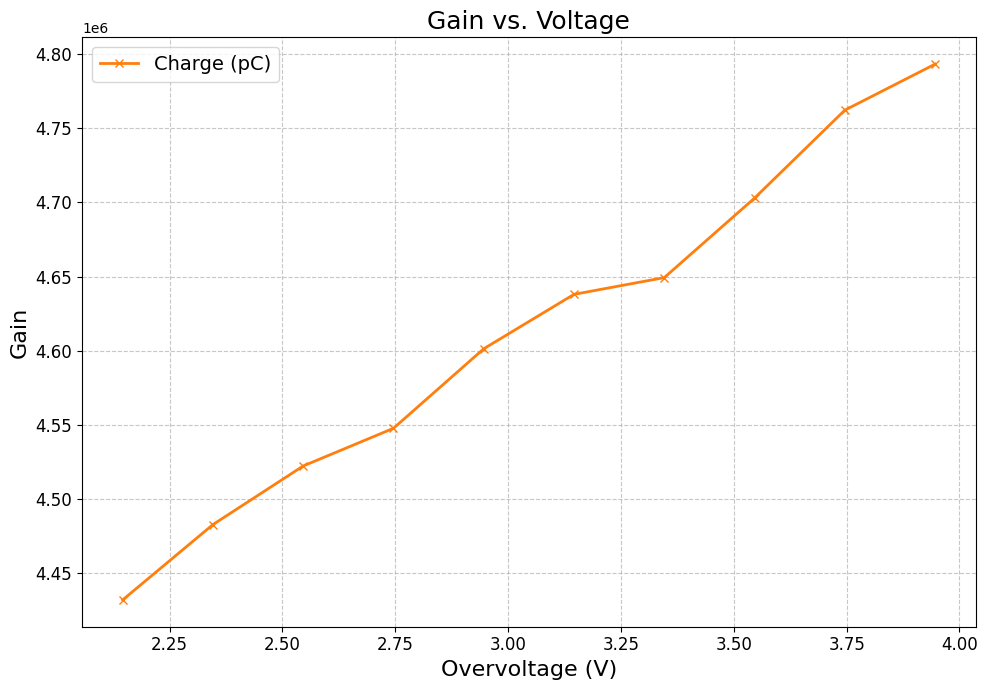


--- Numerical Data ---
Voltage (V) | Peak Difference (Channels) | Charge (pC)
-----------------------------------------------------
66.7        | 17.1                       | 0.71      
66.9        | 18.9                       | 0.72      
67.1        | 20.3                       | 0.72      
67.3        | 21.2                       | 0.73      
67.5        | 23.1                       | 0.74      
67.7        | 24.4                       | 0.74      
67.9        | 24.8                       | 0.74      
68.1        | 26.7                       | 0.75      
68.3        | 28.8                       | 0.76      
68.5        | 29.9                       | 0.77      


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_and_convert_channels_to_charge(voltage_v, peak_difference_channels, K_charge, B_Q):
    """
    Plots the peak difference in channels and the converted charge (pC)
    against voltage (V). Also prints the data in a formatted table.

    Args:
        voltage_v (np.array): Array of voltage values (V).
        peak_difference_channels (np.array): Array of peak differences in channels.
        K_charge (float): Charge-to-channel ratio (channels/pC).
        B_Q (float): Channel offset (channels).
    """
    temp = 21
    Overvoltage = voltage_v-  (63+0.074*temp)
    e = 1.602e-19  # Elementary charge in Coulombs
    pc_to_C = 1e-12 # Conversion factor from pC to Coulombs (1 pC = 10^-12 C)

    # --- Calculations ---
    # Convert channels to Charge (in pC)
    charge_pc = (peak_difference_channels - B_Q) / K_charge

    # Convert Charge to SiPM Gain (number of electrons)
    charge_coulombs = charge_pc * pc_to_C
    sipm_gain_electrons = charge_coulombs / e

    # --- Plotting ---
    plt.figure(figsize=(10, 7)) # Adjust figure size for better readability

    # Plot Converted Charge in pC
    plt.plot(Overvoltage, sipm_gain_electrons, 
             marker='x',  color='tab:orange', 
             label='Charge (pC)', linewidth=2)

    # Set labels and title with larger font sizes
    plt.xlabel('Overvoltage (V)', fontsize=16)
    plt.ylabel('Gain', fontsize=16) # Combined Y-axis label
    plt.title('Gain vs. Voltage', fontsize=18)

    # Customize tick parameters
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.7) # Add grid for better readability
    plt.legend(fontsize=14) # Larger legend font size
    plt.tight_layout() # Adjust layout to prevent labels/title overlapping
    plt.show()

    # --- Print Numerical Output ---
    print("\n--- Numerical Data ---")
    print("Voltage (V) | Peak Difference (Channels) | Charge (pC)")
    print("-----------------------------------------------------")
    for i in range(len(voltage_v)):
        print(f"{voltage_v[i]:<11.1f} | {peak_difference_channels[i]:<26.1f} | {charge_pc[i]:<10.2f}")


if __name__ == "__main__":
    # --- Your Calibration Constants ---
    # These are derived from your charge injection calibration (2pF capacitor)
    K_charge = 221.10  # channels/pC
    B_Q = -139.88      # channels

    # --- Your Data for Plotting ---
    # Voltage (V) values
    voltage_data = np.array([66.7, 66.9, 67.1, 67.3, 67.5, 67.7, 67.9, 68.1, 68.3, 68.5])
    # Peak difference (channels) values
    peak_diff_data = np.array([17.1, 18.9, 20.3, 21.2, 23.1, 24.4, 24.8, 26.7, 28.8, 29.9])

    # Call the function to plot and convert
    plot_and_convert_channels_to_charge(voltage_data, peak_diff_data, K_charge, B_Q)

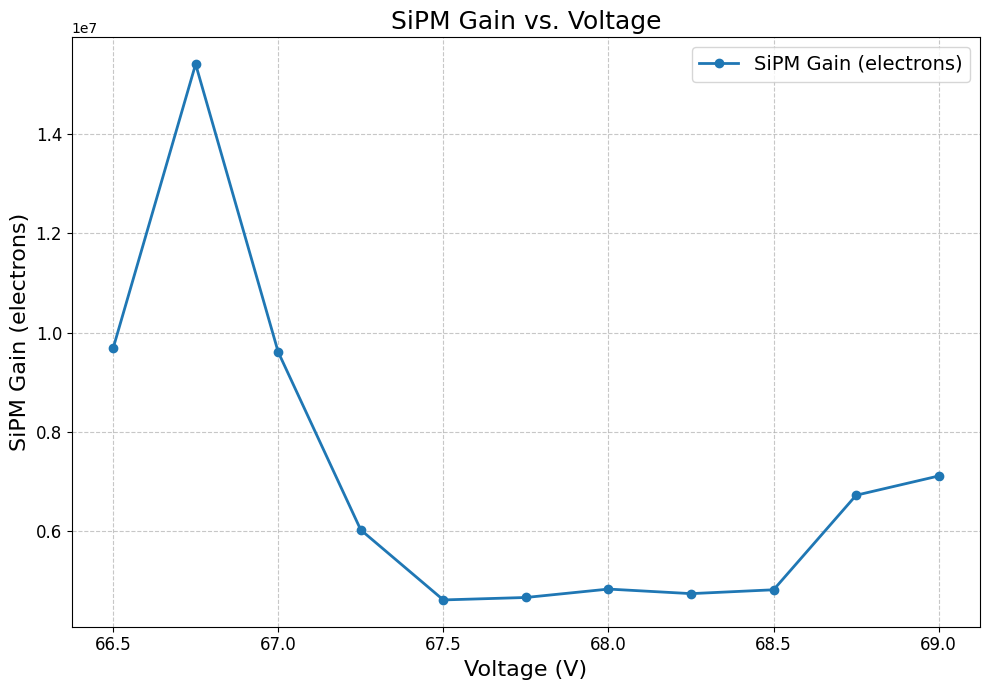


--- Numerical Data ---
Voltage (V) | Peak Diff (Channels) | Charge (pC) | SiPM Gain (electrons)
----------------------------------------------------------------------
66.5        | 203.0                | 1.55        | 9680346             
66.8        | 406.0                | 2.47        | 15411536            
67.0        | 200.5                | 1.54        | 9609765             
67.2        | 73.5                 | 0.97        | 6024242             
67.5        | 23.5                 | 0.74        | 4612619             
67.8        | 25.2                 | 0.75        | 4662026             
68.0        | 31.2                 | 0.77        | 4831421             
68.2        | 28.0                 | 0.76        | 4739665             
68.5        | 30.8                 | 0.77        | 4817304             
68.8        | 98.2                 | 1.08        | 6722996             
69.0        | 112.0                | 1.14        | 7111192             


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def plot_sipm_gain_from_csv(csv_filepath, K_charge, B_Q):
    """
    Reads data from a CSV file, calculates SiPM gain, and plots gain vs. voltage.
    Also prints the data in a formatted table.

    Args:
        csv_filepath (str): Path to the CSV file containing voltage and peak difference.
        K_charge (float): Charge-to-channel ratio (channels/pC).
        B_Q (float): Channel offset (channels).
    """

    if not os.path.exists(csv_filepath):
        print(f"Error: The file '{csv_filepath}' was not found.")
        print("Please ensure the path is correct or the file is in the same directory as this script.")
        return

    try:
        # Read the CSV file
        # Assumes a simple header like "Voltage (V), Peak difference (channels)"
        # If your CSV uses a different separator (e.g., ';') or decimal (e.g., ','),
        # adjust `sep` and `decimal` parameters below.
        df = pd.read_csv(csv_filepath, sep=',', decimal='.') 
        
        # Identify columns robustly based on common names
        # This helps if your CSV column names have slight variations or extra spaces
        voltage_col = next((col for col in df.columns if 'voltage' in col.lower() and '(v)' in col.lower()), None)
        peak_diff_col = next((col for col in df.columns if 'peak difference' in col.lower() or 'channels' in col.lower()), None)

        if not voltage_col or not peak_diff_col:
            print(f"Error: Couldn't find 'Voltage (V)' or 'Peak difference (channels)' columns in '{csv_filepath}'.")
            print(f"Available columns in your file: {df.columns.tolist()}")
            print("Please check your CSV's column headers.")
            return

        voltage_v = df[voltage_col].values
        peak_difference_channels = df[peak_diff_col].values

    except Exception as e:
        print(f"An error occurred while reading or parsing '{csv_filepath}': {e}")
        return

    # --- Constants ---
    e = 1.602e-19  # Elementary charge in Coulombs
    pc_to_C = 1e-12 # Conversion factor from pC to Coulombs (1 pC = 10^-12 C)

    # --- Calculations ---
    # Convert channels to Charge (in pC)
    charge_pc = (peak_difference_channels - B_Q) / K_charge

    # Convert Charge to SiPM Gain (number of electrons)
    charge_coulombs = charge_pc * pc_to_C
    sipm_gain_electrons = charge_coulombs / e

    # --- Plotting ---
    plt.figure(figsize=(10, 7)) # Set plot size for better readability

    plt.plot(voltage_v, sipm_gain_electrons,
             marker='o', linestyle='-', color='tab:blue',
             label='SiPM Gain (electrons)', linewidth=2)

    # Set clear labels and title
    plt.xlabel('Voltage (V)', fontsize=16)
    plt.ylabel('SiPM Gain (electrons)', fontsize=16)
    plt.title('SiPM Gain vs. Voltage', fontsize=18)

    # Customize tick sizes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.7) # Add a subtle grid
    plt.legend(fontsize=14) # Display legend with a larger font
    plt.tight_layout() # Adjust plot to prevent labels from overlapping
    plt.show() # Display the plot

    # --- Print Numerical Output ---
    print("\n--- Numerical Data ---")
    print("Voltage (V) | Peak Diff (Channels) | Charge (pC) | SiPM Gain (electrons)")
    print("----------------------------------------------------------------------")
    for i in range(len(voltage_v)):
        print(f"{voltage_v[i]:<11.1f} | {peak_difference_channels[i]:<20.1f} | {charge_pc[i]:<11.2f} | {int(sipm_gain_electrons[i]):<20}") # Use int for gain if it's a large whole number


if __name__ == "__main__":
    # --- YOUR CALIBRATION CONSTANTS ---
    # These are crucial for converting channels to charge.
    # They come from your 2pF capacitor charge injection calibration.
    K_charge = 221.10  # channels/pC
    B_Q = -139.88      # channels

    # --- PATH TO YOUR CSV FILE ---
    # IMPORTANT: Change this to the actual path of your results.csv file.
    # Example: If your file is directly in a 'SiPM_Spectra' folder
    # that's in the same directory as this Python script:
    csv_file_path = os.path.join("SiPM_Spectra", "results.csv")
    
    # If your file is just "results.csv" in the same directory as the script:
    # csv_file_path = "results.csv"

    # Call the function to run the analysis and plotting
    plot_sipm_gain_from_csv(csv_file_path, K_charge, B_Q)